In [2]:
# If you encounter errors in the code, update the packages
# !pip install scipy==1.10.1
# !pip install numpy==1.21.2
# !pip install pandas==1.3.3

In [3]:
from saver_func import SaveData

save = SaveData.save

# Introduction

## Instructions

You will have **30** total minutes to look through four tasks (10 for tasks 0 and 1, 10 for task 2, and 10 for task 3). Your goal is to understand the purpose of the code, as if to be asked similar tasks. You should strive not only to understand what the code is doing, but also why the code's author made the choices they did. We will follow up this process of discovery with questions asking about your understanding of the material.

Please, do **not** write any additional Pandas code. In order to view intermediate DataFrames or Series, you may make a new line with the function `save()` to save any DataFrame or Series. An example using `Task 0` is seen here:

> ```python
> buoy_raw = pd.read_csv(fp, sep='\s+')
> save(buoy_raw)
> buoy = buoy_raw.dropna()
> ```

You are welcome to run the cells as many times as you need. Further, you may use the `save()` function as many times as you see fit. Be careful not to adjust any code. If you edit any lines, the original code is hidden in a markdown cell at the top of the notebook.

We will interrupt you after 10 minutes to prompt you to complete a [short survey](https://forms.gle/7jdxEDTrbd1EVRHT9) and move on to the next section. If you finish a section early, let us know before you move on.

## Scenario

You have joined a lab at the Scripps Institution of Oceanography. Your coworker, Alex, was tasked to make a quick analysis on a dataset and has since left for vacation. Your boss has asked you to get familiar with Alex's code in order to make additional analysis. Unfortunately for you, their code lacks comments or much neatness. Become familiar with Alex's code for future analysis. Subject matter is not necessary for the analysis tasks.

## Tasks

Broadly, the four tasks are as follows
- **Task 0**: Clean the dataset
- **Task 1**: Assess missingness
    - Definition: Data is considered "missing at random" if the chance that a value is missing depends on other columns, but not the actual missing value itself.
- **Task 2**: Imputation
- **Task 3**: Compare imputation to original

# Alex's Code

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [5]:
### TASK 0

# Link to txt file: https://raw.githubusercontent.com/ch-lum/table_information/main/buoy.txt
# Link to schema: https://www.ndbc.noaa.gov/obsdes.shtml

fp = 'buoy.txt'
buoy_raw = pd.read_csv(fp, sep='\s+')
buoy = buoy_raw.dropna()
buoy = buoy.replace(r"-+$", np.nan, regex=True)
buoy = buoy[buoy["TIME"] != "TIME"]
buoy = buoy.dropna(axis=1, how='all').reset_index(drop=True)
non_numeric_cols = set(['D', 'T1', 'SwD', 'WWD', 'STEEPNESS'])
numeric_cols = list(set(buoy.columns) - non_numeric_cols)
buoy.loc[:, numeric_cols] = buoy.loc[:, numeric_cols].apply(pd.to_numeric, errors='coerce')

buoy

,D,T1,TIME,LAT,LON,DIST,HDG,WDIR,WSPD,GST,...,S1HT,S1PD,S1DIR,SwH,SwP,SwD,WWH,WWP,WWD,STEEPNESS
0,46275,B,2100.0,33.29,-117.5,28.0,334.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.95,16.7,SW,1.97,5.6,W,SWELL
1,46086,B,2100.0,32.5,-118.05,46.0,241.0,280.0,9.7,13.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SHIP,S,2100.0,33.6,-118.7,85.0,302.0,300.0,9.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,46025,B,2110.0,33.76,-119.05,104.0,301.0,290.0,7.8,9.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,46025,B,2100.0,33.76,-119.05,104.0,301.0,280.0,7.8,9.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,MBXC1,O,910.0,35.37,-120.86,233.0,311.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2492,MBXC1,O,900.0,35.37,-120.86,233.0,311.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2493,46259,B,956.0,34.77,-121.5,240.0,300.0,NaN,NaN,NaN,...,NaN,NaN,NaN,5.25,10.5,NW,8.2,7.7,NW,AVERAGE
2494,46259,B,926.0,34.77,-121.5,240.0,300.0,NaN,NaN,NaN,...,NaN,NaN,NaN,4.59,10.5,NW,8.86,9.9,NW,AVERAGE


variable
APD          True
ATMP         True
DEWP         True
DPD          True
GST          True
MWD          True
PRES         True
PTDY         True
S1DIR        True
S1HT         True
S1PD         True
STEEPNESS    True
SwD          True
SwH          True
SwP          True
TCC          True
VIS          True
WDIR         True
WSPD         True
WTMP         True
WVHT         True
WWD          True
WWH          True
WWP          True
dtype: bool

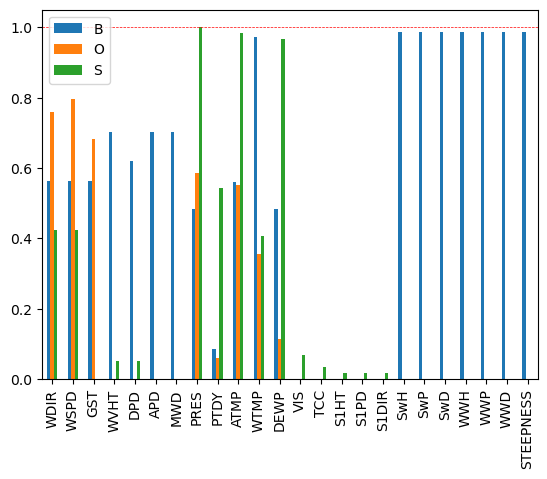

In [6]:
### TASK 1

totals = buoy["T1"].value_counts()
missing_some = buoy.drop(buoy.columns[~buoy.isnull().any()].drop("T1"), axis=1)
present_counts = missing_some.groupby("T1").count()
cont_tables = present_counts.melt(ignore_index=False).rename(
    columns={"value": "Present"}
)
cont_tables["Missing"] = cont_tables.groupby("variable")["Present"].transform(
    lambda x: totals - x
)
missingness = cont_tables.groupby("variable").apply(
    lambda x: stats.chi2_contingency(x).pvalue < 0.0001
)
present_props = present_counts.div(totals, axis=0)
present_props.T.plot(kind="bar").axhline(
    y=1.0, color="red", linestyle="--", linewidth=0.5
)

missingness

In [7]:
### TASK 2

no_ships = buoy.groupby("T1").filter(lambda x: len(x) > 200)
melted = no_ships.melt(id_vars="T1", ignore_index=False)
melted = melted.groupby("variable").filter(
    lambda x: x.groupby("T1")["value"].count().min() > 200
)
un_melted = melted.reset_index().pivot(
    index="index", columns="variable", values="value"
)
no_ships = pd.concat([no_ships["T1"], un_melted], axis=1).reset_index(drop=True)
quantiles = pd.qcut(no_ships["TIME"], 25)
missing_cols = no_ships.isnull().any()
means = no_ships.groupby([quantiles, "T1"])[
    no_ships.columns[missing_cols]
].mean()
imputation = (
    pd.merge(
        no_ships.set_index([quantiles, "T1"]).loc[:, "D"],
        means,
        left_index=True,
        right_index=True,
    )
    .loc[:, missing_cols]
    .reset_index()
)
imputed = no_ships.copy()
imputed.loc[:, missing_cols] = no_ships.loc[:, missing_cols].combine_first(
    imputation.loc[:, missing_cols]
)

imputed

,T1,ATMP,D,DIST,GST,HDG,LAT,LON,PRES,TIME,WDIR,WSPD,WTMP
0,B,60.3,46275,28.0,16.838095,334.0,33.29,-117.5,29.962222,2100.0,294.761905,12.480952,63.3
1,B,57.9,46086,46.0,13.6,241.0,32.5,-118.05,29.98,2100.0,280.0,9.7,61.0
2,B,57.9,46025,104.0,9.7,301.0,33.76,-119.05,30.02,2110.0,290.0,7.8,61.9
3,B,57.7,46025,104.0,9.7,301.0,33.76,-119.05,30.02,2100.0,280.0,7.8,61.9
4,B,56.8,46047,118.0,21.4,257.0,32.39,-119.53,30.04,2110.0,310.0,17.5,58.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,O,59.388889,MBXC1,233.0,10.5,311.0,35.37,-120.86,30.010714,920.0,229.189189,8.067568,58.3
2433,O,59.388889,MBXC1,233.0,10.5,311.0,35.37,-120.86,30.010714,910.0,229.189189,8.067568,58.1
2434,O,59.388889,MBXC1,233.0,10.5,311.0,35.37,-120.86,30.010714,900.0,229.189189,8.067568,57.9
2435,B,59.388889,46259,240.0,10.5,300.0,34.77,-121.5,30.010714,956.0,229.189189,8.067568,55.8


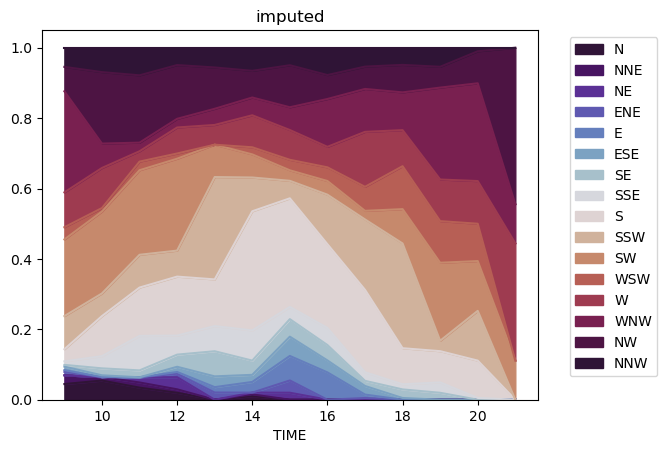

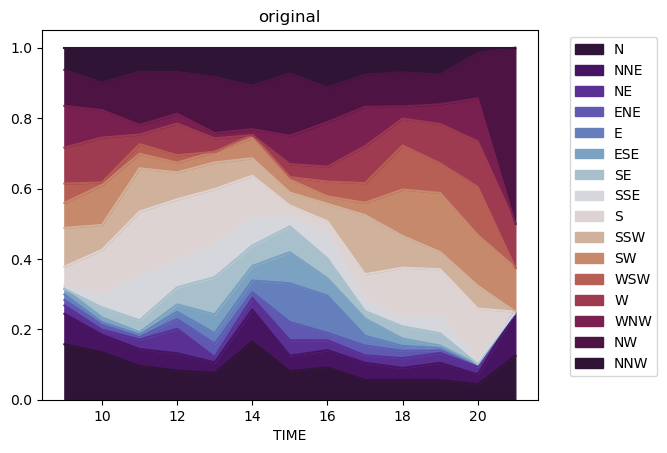

In [8]:
### TASK 3

together = pd.concat([imputed, no_ships], keys=["imputed", "original"])
together = together[(together["TIME"] >= 900) & (together["TIME"] <= 2100)]
together = together[["TIME", "WDIR"]]
together.loc[:, "WDIR_adj"] = (together["WDIR"] + (360 / 16 / 2)) % 360
together = together.reset_index()
directions = pd.cut(
    together["WDIR_adj"], bins=np.linspace(0, 360, 17), include_lowest=True
)
hours = together["TIME"] // 100
d_h = together.pivot_table(
    index=["level_0", hours],
    columns=directions,
    values="TIME",
    aggfunc="count",
)
d_h.columns = [
    "N",
    "NNE",
    "NE",
    "ENE",
    "E",
    "ESE",
    "SE",
    "SSE",
    "S",
    "SSW",
    "SW",
    "WSW",
    "W",
    "WNW",
    "NW",
    "NNW",
]
d_h = d_h.fillna(0)
d_h_props = d_h.div(d_h.sum(axis=1), axis=0)

for key in d_h.index.levels[0]:
    axes = d_h_props.xs(key).plot(kind="area", colormap="twilight_shifted")
    axes.set_title(key)
    axes.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

## Code (in markdown)

```python
import pandas as pd
import numpy as np
import scipy.stats as stats

################################################################

### TASK 0

# Link to txt file: https://raw.githubusercontent.com/ch-lum/table_information/main/buoy.txt
# Link to schema: https://www.ndbc.noaa.gov/obsdes.shtml

fp = 'buoy.txt'
buoy_raw = pd.read_csv(fp, sep='\s+')
buoy = buoy_raw.dropna()
buoy = buoy.replace(r"-+$", np.nan, regex=True)
buoy = buoy[buoy["TIME"] != "TIME"]
buoy = buoy.dropna(axis=1, how='all').reset_index(drop=True)
buoy.iloc[:, 2:-5] = buoy.iloc[:, 2:-5].apply(pd.to_numeric, errors='coerce')
buoy.iloc[:, -4:-2] = buoy.iloc[:, -4:-2].apply(pd.to_numeric, errors='coerce')

buoy

################################################################

### TASK 1

totals = buoy["T1"].value_counts()
missing_some = buoy.drop(buoy.columns[~buoy.isnull().any()].drop("T1"), axis=1)
present_counts = missing_some.groupby("T1").count()
cont_tables = present_counts.melt(ignore_index=False).rename(
    columns={"value": "Present"}
)
cont_tables["Missing"] = cont_tables.groupby("variable")["Present"].transform(
    lambda x: totals - x
)
missingness = cont_tables.groupby("variable").apply(
    lambda x: stats.chi2_contingency(x).pvalue< 0.0001
)
present_props = present_counts.div(totals, axis=0)
present_props.T.plot(kind="bar").axhline(
    y=1.0, color="red", linestyle="--", linewidth=0.5
)

missingness

################################################################

### TASK 2

no_ships = buoy.groupby("T1").filter(lambda x: len(x) > 200)
melted = no_ships.melt(id_vars="T1", ignore_index=False)
melted = melted.groupby("variable").filter(
    lambda x: x.groupby("T1")["value"].count().min() > 200
)
un_melted = melted.reset_index().pivot(
    index="index", columns="variable", values="value"
)
no_ships = pd.concat([no_ships["T1"], un_melted], axis=1).reset_index(drop=True)
quantiles = pd.qcut(no_ships["TIME"], 25)
missing_cols = no_ships.isnull().any()
means = no_ships.groupby([quantiles, "T1"])[
    no_ships.columns[missing_cols]
].mean()
imputation = (
    pd.merge(
        no_ships.set_index([quantiles, "T1"]).loc[:, "D"],
        means,
        left_index=True,
        right_index=True,
    )
    .loc[:, missing_cols]
    .reset_index()
)
imputed = no_ships.copy()
imputed.loc[:, missing_cols] = no_ships.loc[:, missing_cols].combine_first(
    imputation.loc[:, missing_cols]
)

imputed

################################################################

### TASK 3

together = pd.concat([imputed, no_ships], keys=["imputed", "original"])
together = together[(together["TIME"] >= 900) & (together["TIME"] <= 2100)]
together = together[["TIME", "WDIR"]]
together.loc[:, "WDIR_adj"] = (together["WDIR"] + (360 / 16 / 2)) % 360
together = together.reset_index()
directions = pd.cut(
    together["WDIR_adj"], bins=np.linspace(0, 360, 17), include_lowest=True
)
hours = together["TIME"] // 100
d_h = together.pivot_table(
    index=["level_0", hours],
    columns=directions,
    values="TIME",
    aggfunc="count",
)
d_h.columns = [
    "N",
    "NNE",
    "NE",
    "ENE",
    "E",
    "ESE",
    "SE",
    "SSE",
    "S",
    "SSW",
    "SW",
    "WSW",
    "W",
    "WNW",
    "NW",
    "NNW",
]
d_h = d_h.fillna(0)
d_h_props = d_h.div(d_h.sum(axis=1), axis=0)

for key in d_h.index.levels[0]:
    axes = d_h_props.xs(key).plot(kind="area", colormap="twilight_shifted")
    axes.set_title(key)
    axes.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
```